In [12]:
import cv2
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage as ski
from skimage import io, color
from skimage.feature import peak_local_max
from skimage.draw import circle_perimeter
from skimage.transform import hough_circle, hough_circle_peaks
%matplotlib inline


In [2]:
def process_video_into_frames(vod_name, start_time, end_time):
    filepath = f"./vods/{vod_name}.mp4"
    frames_folder_path = f"frames/{vod_name}/"
    
    if not os.path.exists(frames_folder_path):
        os.mkdir(frames_folder_path)
    
    vod_object = cv2.VideoCapture(filepath) 
    fps = int(vod_object.get(cv2.CAP_PROP_FPS))
    
    frame_count = 0
    timer = start_time
    success = True
    
    x, y = 0, 0
    w = int(vod_object.get(cv2.CAP_PROP_FRAME_WIDTH) * 2 // 3)
    h = int(vod_object.get(cv2.CAP_PROP_FRAME_HEIGHT) / 2)
    
    
    
    while success and timer <= end_time:
        vod_object.set(cv2.CAP_PROP_POS_FRAMES, timer * fps)
        success, image = vod_object.read()
        cropped = image[y:y+h, x:x+w]
        
        if success:
            cv2.imwrite(f"{frames_folder_path}/frame_{frame_count}_{timer // 60}_{timer % 60}.jpg", cropped)
            frame_count += 1
            
        timer += 1
        
    vod_object.release()


In [3]:
process_video_into_frames("prx_vs_eg", 4, 2673)

In [56]:
process_video_into_frames("test_1", 3, 5)

In [7]:
def scale(val, frameSize):
    return val * frameSize // 720

def mag(n):
    return sum(x**2 for x in n)

def color_difference_calculator(image, target_color, x, y, w, h):
    cropped_image = image[y:y+h, x:x+w]
    msq = 0
    
    for x in cropped_image:
        for y in x:
            msq += mag(y - target_color)
    
    return (msq / (w * h))**(1/2)
    

def identify_valid_frame(filepath):
    frame = Image.open(filepath)
    frame_arr = np.array(frame)
    target_color = [16, 25, 34]
    x,y,w,h = scale(590, 1080), scale(8, 1080), 2, 16
    
    black_bar = color_difference_calculator(frame_arr, target_color, x, y, w, h)
    
    target_color = [45, 138, 119]
    x,y,w,h = scale(537, 1080), scale(8, 1080), 2, 20
    
    green_bar = color_difference_calculator(frame_arr, target_color, x, y, w, h)
    
    target_color = [111, 57, 71]
    x,y,w,h = scale(742, 1080), scale(8, 1080), 2, 20
    
    red_bar = color_difference_calculator(frame_arr, target_color, x, y, w, h)
    
    return black_bar, green_bar, red_bar


In [20]:
def identify_map_border(image):
    x, y, x2, y2 = scale(35, 1080), scale(50, 1080), scale(264, 1080), scale(260, 1080)
    cropped_map = image[y:y2, x:x2]
    edges = ski.filters.sobel(cropped_map)
    gray_edges = ski.color.rgb2gray(edges)
    min_radius = 5
    max_radius = 20

    # Detect circles using Hough Circle Transform
    hough_radii = np.arange(min_radius, max_radius, 1)
    hough_res = hough_circle(gray_edges, hough_radii)

    # Select the most prominent circles
    accums, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii,
                                               total_num_peaks=10)

    # Draw detected circles
    fig, ax = plt.subplots()
    ax.imshow(gray_edges)

    for center_y, center_x, radius in zip(cy, cx, radii):
        circy, circx = circle_perimeter(center_y, center_x, radius)
        #ax.plot(circx, circy, 'r-', linewidth=1)

    plt.show()



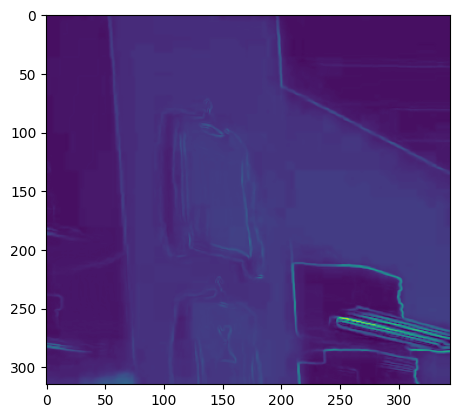

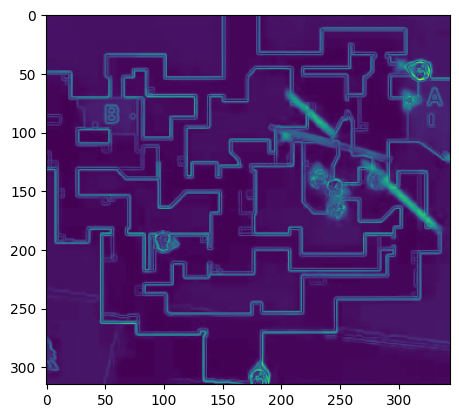

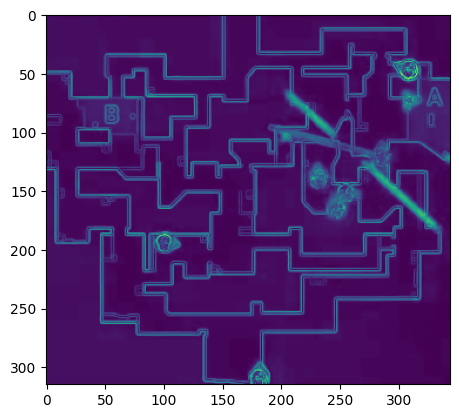

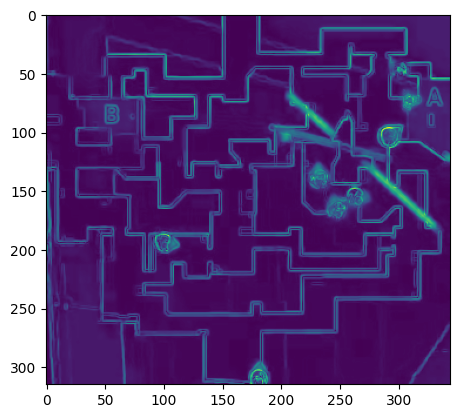

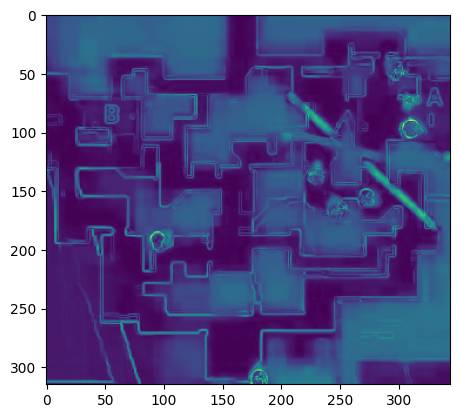

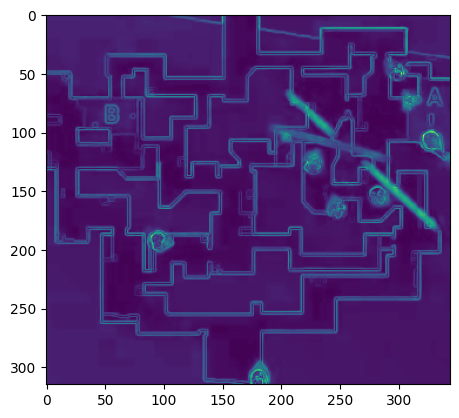

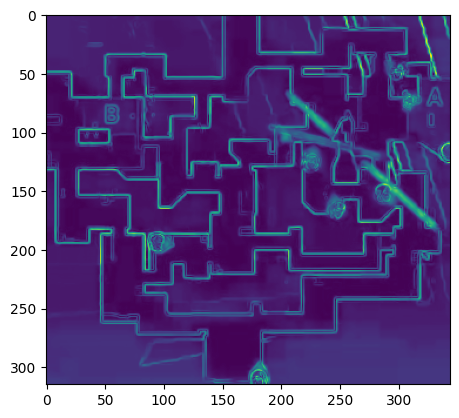

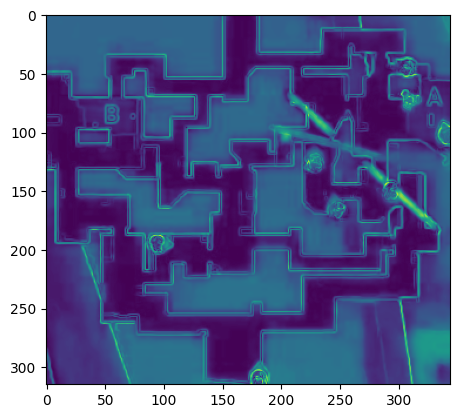

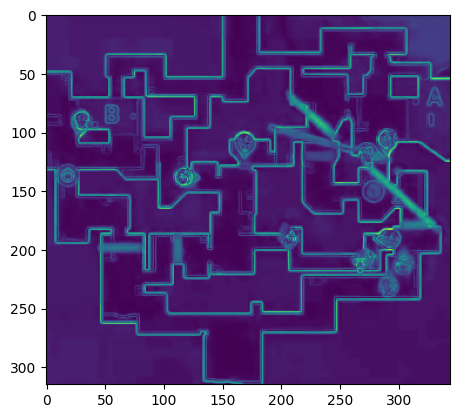

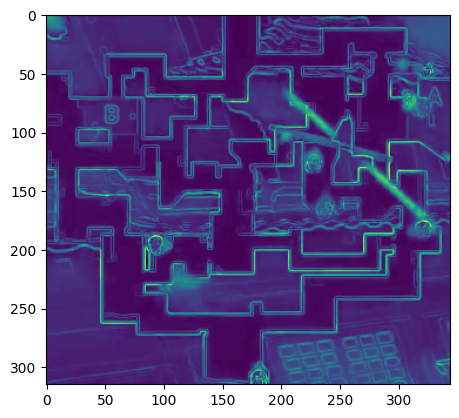

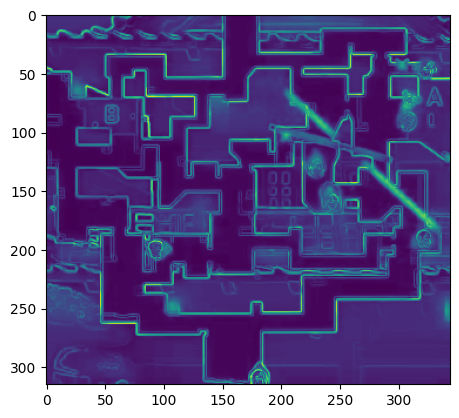

In [21]:

folder_path = 'frames/prx_vs_eg/'

files = os.listdir(folder_path)
counter = 0

for file_name in files:
    filepath = os.path.join(folder_path, file_name)
    if os.path.isfile(filepath):
        black, green, red = identify_valid_frame(filepath)
        if black < 15 and green < 50 and red < 50:
            frame = Image.open(filepath)
            frame_arr = np.array(frame)
            identify_map_border(frame_arr)
            counter +=1
            if counter > 10:
                break